<a href="https://colab.research.google.com/github/bnguy024/Movie-Recommender-System-/blob/main/movie_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Movie Recommender System
This project is an exploration of building a recommender system that uses collaborative filtering in python. The data set for this recommender system is from [MovieLens](https://https://movielens.org/), by GroupLens.


In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Load Data
ratings = pd.read_csv('https://docs.google.com/uc?export=download&id=1rAe7ntpgi0mzpbIgAv3sXHXXmx15aV7v')
movies = pd.read_csv('https://docs.google.com/uc?export=download&id=16b44gfTExl0o7R0TOKodmE5567oRxILU')

In [ ]:
#Show the headers for rating
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
#Display the data
n_ratings = len(ratings)
## Number of Unique Movies
n_movies = ratings['movieId'].nunique()
## Number of Unique Users
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


#The Distribution of Movie Ratings
We will explore the distribution of movie ratings to find out user rating patterns



<ipython-input-11-292c6ee4e6c4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis' )


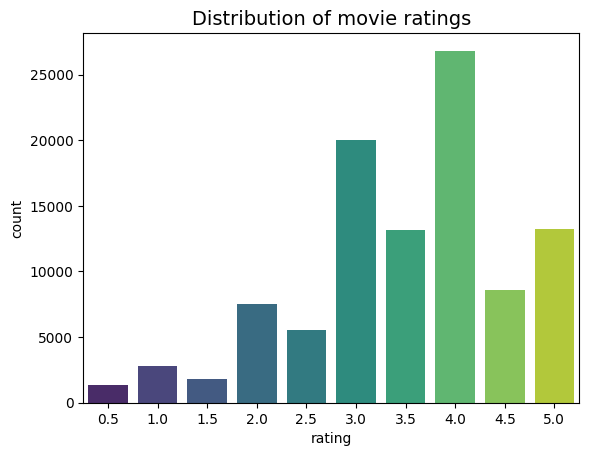

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [ ]:
#Show the distribution of movie ratings
sns.countplot(x='rating', data=ratings, palette='viridis' )
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()
#Display gobal mean rating
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

In [ ]:
#Explore which movies are most frequently rated
ratings['movieId'].value_counts()
#get movie title by merging with movieId
movie_ratings = ratings.merge(movies, on='movieId')
#show movie rating by title and rating count
movie_ratings['title'].value_counts()[0:10]

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


Which movies have the lowest and highest rating?

In [ ]:
#Explore which are the lowest and highest rated movies
mean_ratings = ratings.groupby('movieId')[['rating']].mean()

#Get the index that has the lowest rating
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId'] == lowest_rated  ]

,movieId,title,genres
2689,3604,Gypsy (1962),[Musical]


In [ ]:
#Get the index of the movie with the Highest Rating
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),"[Adventure, Drama]"


In [ ]:
ratings[ratings['movieId']==lowest_rated]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


In [ ]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Although 'Gypsy' and 'Lamerica' are the lowest and highest rated movies, they have very few ratings. A better approach for evalutating movie popularity would be using The Bayesian Average



#Implement the Bayesian Average


In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean' ].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [ ]:
lamerica = pd.Series([5,5])
bayesian_avg(lamerica)

3.543

In [ ]:
#reset_idex() to change from panda series to data frame
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
#rename the columns
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
#append bayesian avg rating to movie stats
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
#merge movie df and movie stats df
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
#sort titles by bayesian average
movie_stats.sort_values(by='bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [ ]:
#give us the top 5 lowest rated movies
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


Through using the bayesian average, it gives us a more accurate look at which movies are the lowest and highest rated


#Movie Genres
Next we will take a look at movie genres in order to implement it in our collaborative filtering technique

In [ ]:
#Clean Genre since there is a "|" between each genre
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


What is the count of each genre in the dataset?


In [ ]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [ ]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))


The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


#Visualize the Distribution of Movie Genres

<ipython-input-26-4fa42d19ba7d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette='viridis')


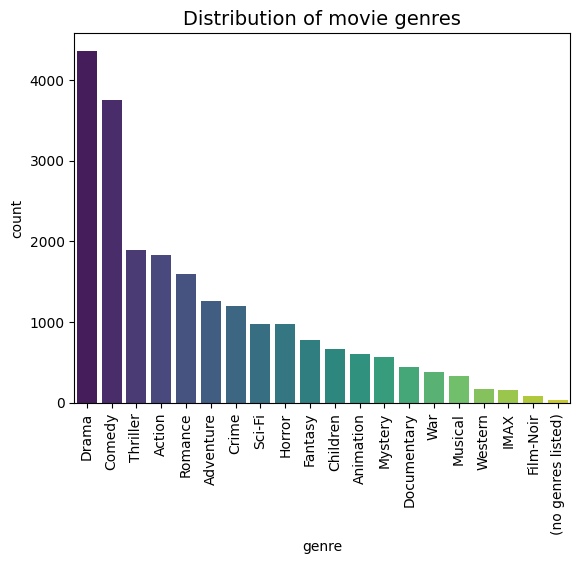

In [ ]:
#flip row to column and reset index to make genre its own column
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

#plot a bar plot showing the frequency of each genre
sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette='viridis')
plt.xticks(rotation=90)
plt.title("Distribution of movie genres", fontsize=14)
plt.xticks(rotation=90)
plt.show()

#Transforming The Data
In order to use colaborative filtering to generate recommendations. We have to first transform our data into a user-item matrix. Where the rows represents the users, and the columns represents the movies.

In [ ]:
#Process our data so that we can perform colaborative filtering to generate recommendations for users
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

X.shape

(610, 9724)

Evaluate The Sparsity bewteen each row/column


In [ ]:
n_total = X.shape[0]*X.shape[1]
#counts the number of stored non empty elements in the matrix
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Lastly, we will check that every movie at least has 1 rating


In [ ]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [ ]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [ ]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [ ]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


#Visualize the Number of Ratings per User and Movies

<ipython-input-33-44089890dcd7>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
<ipython-input-33-44089890dcd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


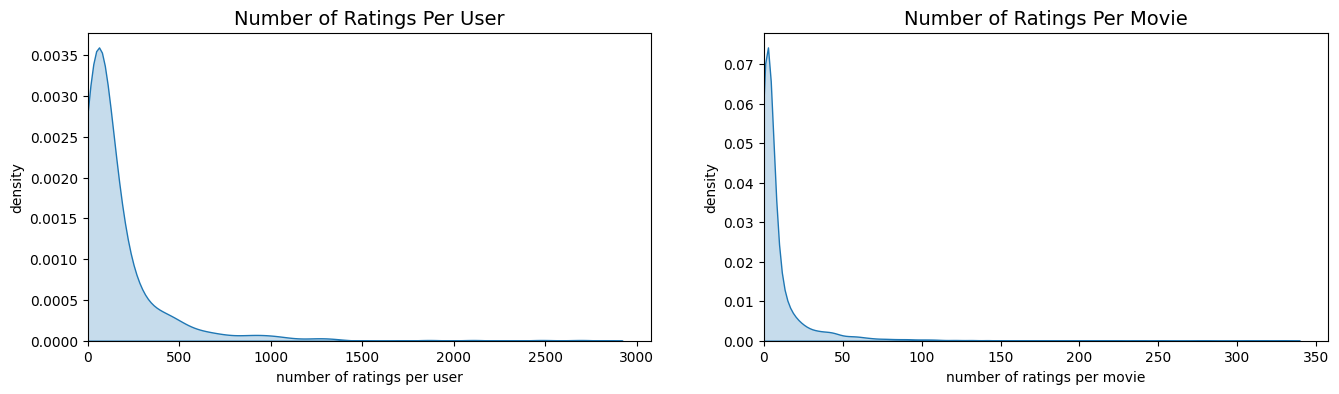

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

#Recommendation Function using K-Nearest Neighbors
We will use k-nearest neighbors algorithm to give us the recommendation based on our matrix table that we generated

In [ ]:
from sklearn.neighbors import NearestNeighbors
# recommend_movies() takes in a movieId and X matrix, and outputs a list of  k  movies that are similar to the movieId of interest.
def recommend_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors= k+1 , algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
similar_movies = recommend_movies(1213, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[1089, 858, 1221, 608, 296, 50, 1208, 2329, 1222]

Let's input in the movie "GoodFellas" and see what recommendations we get!


In [ ]:
#recommend_movies() returns a list of movieID's, so we'll conevert these ID's into titles
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1213

similar_movies = recommend_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
  print(movie_titles[i])

Because you watched Goodfellas (1990):
Reservoir Dogs (1992)
Godfather, The (1972)
Godfather: Part II, The (1974)
Fargo (1996)
Pulp Fiction (1994)
Usual Suspects, The (1995)
Apocalypse Now (1979)
American History X (1998)
Full Metal Jacket (1987)


Based on the recommendations, we have been recommended:
*   Reservoir Dogs (1992)
*   Godfather, The (1972)
*   Godfather: Part II, The (1974)
*   Fargo (1996)
*   Pulp Fiction (1994)
*   Usual Suspects, The (1995)
*   Apocalypse Now (1979)
*   American History X (1998)
*   Full Metal Jacket (1987)

Which are excellent recommendations based on how similar they are to Goodfellas, since they are close to the same genre and director.

